# CSCA 5642 Introduction to Deep Learning Week 4 Homework

## Preparation

In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import random
import keras_tuner as kt

# fix random seed for reproducibility
SEED = 0
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [32]:
project_root = '/home/lee/Documents/CSCA5642/week4/'
data_folder = os.path.join(project_root, 'nlp-getting-started')
model_folder = os.path.join(project_root, 'models')

train_orig = pd.read_csv(os.path.join(data_folder, 'train.csv'))
test_orig = pd.read_csv(os.path.join(data_folder, 'test.csv'))

## Description of the problem and data

**Data source**: https://www.kaggle.com/c/nlp-getting-started/

**Challenge problem**: This is a binary text classification problem. The input dataset contains Twitter tweets. Our task is to use deep learning techniques to identify if the tweet is describing a real disaster or otherwise. 

### Size

In [5]:
print(f"Training data size: {train_orig.size}")
print(f"Test data size: {test_orig.size}")

Training data size: 38065
Test data size: 13052


### Dimension

In [6]:
print(f"Training data shape: {train_orig.shape}")
print(f"Test data shape: {test_orig.shape}")

Training data shape: (7613, 5)
Test data shape: (3263, 4)


### Structure

In [7]:
print(f'Training data structure: \n{train_orig.head()}')
print(f'Test data structure: \n{test_orig.head()}')

Training data structure: 
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
Test data structure: 
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor ki

## Exploratory Data Analysis (EDA)

### Inspect the Data

In [8]:
train_orig['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [9]:
train_orig['target'].value_counts(normalize=True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

### Visualize the Data

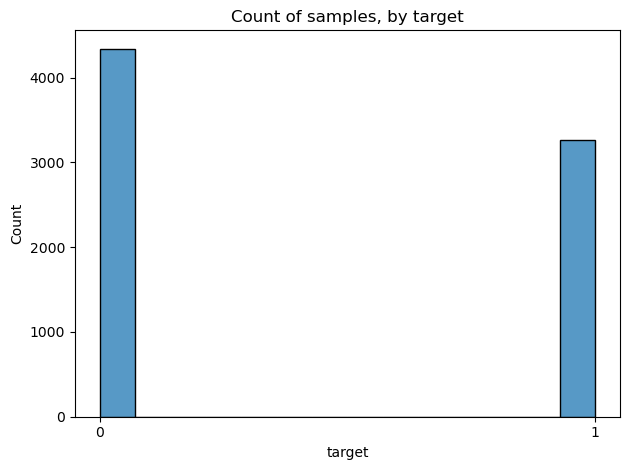

In [10]:
sns.histplot(train_orig, x='target')
plt.xticks([0, 1])
plt.title('Count of samples, by target')
plt.tight_layout()
plt.show()

## Analysis plan

Upon inspecting the data, we notice that many tweets contain hashtags; we will remove the pound sign from the tweets. Apart from this, due to time constraints, we will not perform extensive preprocessing of the text; we will only apply tokenization and padding/truncating each tweet to a fixed length.

After processing the data we will fit a RNN model to perform this text classification. Then we will fit another RNN model with a different architecture and compare their performances. Then we will perform hyperparameter tuning on the selected model. 

### Utilities

In [13]:
def summarize_history(model_history):
    """Plot the relationship between the number of epochs and the selected model performance metric.
    This plot can inform us whether we should train the model using more or fewer epochs. 
    """
    sns.lineplot(model_history.history['accuracy'], color='blue', label='train')
    sns.lineplot(model_history.history['val_accuracy'], color='green', label='validation')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='best')

hparams = {
    "batch_size": 16,
    "epochs": 10,
    "constraint_learning_rate": 0.01,
    "embedding_dim": 32,
    "embedding_trainable": False,
    "learning_rate": 0.005,
    "max_num_words": 1000,
    "max_sequence_length": 20,
    "lstm_units": 32,
}

## Model Architecture

We will fit multiple Long Short-Term Memory (LSTM) neural network models.

Recurrent Neural Networks (RNNs) are commonly used in natural language processing tasks. RNNs are designed to handle sequential data by maintaining a hidden state that captures information about previous inputs in the sequence. They process input data step by step, updating their hidden state at each time step based on the current input and the previous hidden state. However, traditional RNNs suffer from the vanishing gradient problem, where gradients diminish as they are backpropagated through time, making it difficult for the network to learn long-range dependencies. This is why we use a LSTM model instead of vanilla RNN. LSTMs are a type of RNN specifically designed to address the vanishing gradient problem and capture long-range dependencies more effectively.

### Define the RNN model

My first RNN model contains one embedding layer to process the text and one LSTM layer. 

In [14]:
model_lstm = models.Sequential([
    layers.Embedding(input_dim=hparams["max_num_words"], output_dim=hparams["embedding_dim"], input_length=hparams["max_sequence_length"]),
    layers.LSTM(hparams["lstm_units"]),
    layers.Dense(units=1, activation='sigmoid')
])


model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2024-02-29 15:08:25.786040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 15:08:25.799093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 15:08:25.799193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Model comparison

My second RNN model still contains one embedding layer to process the text and one LSTM layer, but a batch normalization layer is added after the LSTM layer. 

In [15]:
# Modify the model architecture to add Batch Normalization
model_lstm_bn = models.Sequential()
model_lstm_bn.add(layers.Embedding(input_dim=hparams["max_num_words"], output_dim=hparams["embedding_dim"]))
model_lstm_bn.add(layers.LSTM(units=hparams["lstm_units"]))
model_lstm_bn.add(layers.BatchNormalization())
model_lstm_bn.add(layers.Dense(units=1, activation='sigmoid'))

# Compile the modified model
model_lstm_bn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Results and analysis

### Prepare training data

In [16]:
train_orig['removepound'] = train_orig['text'].str.replace('#', '')

# Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(train_orig['removepound'], train_orig['target'], test_size=0.2, random_state=42)

# Tokenize the texts
tokenizer = Tokenizer(num_words=hparams["max_num_words"])
tokenizer.fit_on_texts(train_texts)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences to have the same length
train_data = pad_sequences(train_sequences, maxlen=hparams["max_sequence_length"])
test_data = pad_sequences(test_sequences, maxlen=hparams["max_sequence_length"])

### Train the model

In [17]:
history_lstm = model_lstm.fit(train_data, train_labels, epochs=hparams["epochs"], batch_size=hparams["batch_size"], validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model_lstm.evaluate(test_data, test_labels)
print(f'Test Accuracy: {test_acc}')

Epoch 1/10


2024-02-29 15:08:37.443329: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2024-02-29 15:08:37.477667: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe968565050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-29 15:08:37.477682: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2024-02-29 15:08:37.480160: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-29 15:08:37.488651: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:543] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
 

305/305 [==============================] - 5s 14ms/step - loss: 0.5559 - accuracy: 0.7022 - val_loss: 0.4835 - val_accuracy: 0.7660
Epoch 2/10
305/305 [==============================] - 1s 3ms/step - loss: 0.4068 - accuracy: 0.8212 - val_loss: 0.4600 - val_accuracy: 0.7890
Epoch 3/10
305/305 [==============================] - 1s 2ms/step - loss: 0.3698 - accuracy: 0.8368 - val_loss: 0.4799 - val_accuracy: 0.7865
Epoch 4/10
305/305 [==============================] - 1s 2ms/step - loss: 0.3542 - accuracy: 0.8459 - val_loss: 0.5048 - val_accuracy: 0.7833
Epoch 5/10
305/305 [==============================] - 1s 2ms/step - loss: 0.3393 - accuracy: 0.8553 - val_loss: 0.5043 - val_accuracy: 0.7898
Epoch 6/10
305/305 [==============================] - 1s 2ms/step - loss: 0.3258 - accuracy: 0.8580 - val_loss: 0.5081 - val_accuracy: 0.7931
Epoch 7/10
305/305 [==============================] - 1s 2ms/step - loss: 0.3088 - accuracy: 0.8744 - val_loss: 0.5696 - val_accuracy: 0.7791
Epoch 8/10
305/3

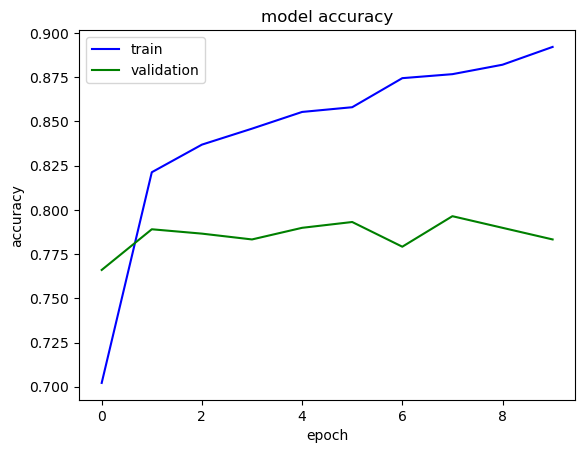

In [19]:
summarize_history(history_lstm)

### Train the other RNN model

In [18]:
history_lstm_bn = model_lstm_bn.fit(train_data, train_labels, epochs=hparams["epochs"], batch_size=hparams["batch_size"], validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model_lstm_bn.evaluate(test_data, test_labels)
print(f'Test Accuracy: {test_acc}')

Epoch 1/10
305/305 [==============================] - 5s 12ms/step - loss: 0.5338 - accuracy: 0.7334 - val_loss: 0.5899 - val_accuracy: 0.7365
Epoch 2/10
305/305 [==============================] - 1s 3ms/step - loss: 0.4270 - accuracy: 0.8091 - val_loss: 0.5103 - val_accuracy: 0.7734
Epoch 3/10
305/305 [==============================] - 1s 2ms/step - loss: 0.3808 - accuracy: 0.8325 - val_loss: 0.5488 - val_accuracy: 0.7479
Epoch 4/10
305/305 [==============================] - 1s 2ms/step - loss: 0.3429 - accuracy: 0.8567 - val_loss: 0.5439 - val_accuracy: 0.7644
Epoch 5/10
305/305 [==============================] - 1s 2ms/step - loss: 0.3102 - accuracy: 0.8684 - val_loss: 0.9111 - val_accuracy: 0.7447
Epoch 6/10
305/305 [==============================] - 1s 2ms/step - loss: 0.2898 - accuracy: 0.8732 - val_loss: 0.6884 - val_accuracy: 0.7455
Epoch 7/10
305/305 [==============================] - 1s 2ms/step - loss: 0.2716 - accuracy: 0.8834 - val_loss: 0.7087 - val_accuracy: 0.7586
Epoch

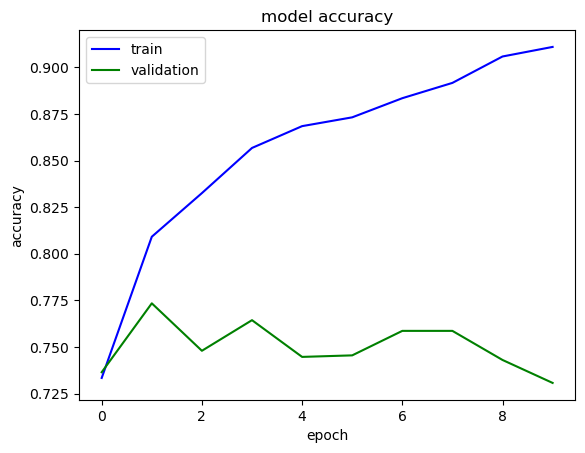

In [20]:
summarize_history(history_lstm_bn)

We will proceed with the model without the BatchNormalization layer. Next we will optimize it via hyperparameter tuning.

### Hyperparameter optimization

In [21]:
def model_builder(hp):

    model = models.Sequential()
    model.add(layers.Embedding(input_dim=hparams["max_num_words"], output_dim=hparams["embedding_dim"], input_length=hparams["max_sequence_length"]))
    hp_units = hp.Int('units', min_value=16, max_value=128, step=16)
    model.add(layers.LSTM(hp_units))
    model.add(layers.Dense(units=1, activation='sigmoid'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])

    return model

In [22]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=hparams["epochs"],
                     factor=3,
                     )

In [23]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [24]:
tuner.search(train_data, train_labels, epochs=hparams["epochs"], validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the LSTM
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 09s]
val_accuracy: 0.7783251404762268

Best val_accuracy So Far: 0.7972085475921631
Total elapsed time: 00h 03m 05s

The hyperparameter search is complete. The optimal number of units in the LSTM
layer is 16 and the optimal learning rate for the optimizer
is 0.001.



In [25]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model_tuned = tuner.hypermodel.build(best_hps)
history_tuned = model_tuned.fit(train_data, train_labels, epochs=hparams["epochs"], validation_split=0.2)

Epoch 1/10
153/153 [==============================] - 4s 23ms/step - loss: 0.6124 - accuracy: 0.6626 - val_loss: 0.5337 - val_accuracy: 0.7504
Epoch 2/10
153/153 [==============================] - 1s 5ms/step - loss: 0.4409 - accuracy: 0.8081 - val_loss: 0.4575 - val_accuracy: 0.7915
Epoch 3/10
153/153 [==============================] - 1s 3ms/step - loss: 0.3794 - accuracy: 0.8417 - val_loss: 0.4771 - val_accuracy: 0.7742
Epoch 4/10
153/153 [==============================] - 0s 2ms/step - loss: 0.3592 - accuracy: 0.8491 - val_loss: 0.4861 - val_accuracy: 0.7906
Epoch 5/10
153/153 [==============================] - 0s 2ms/step - loss: 0.3453 - accuracy: 0.8573 - val_loss: 0.4821 - val_accuracy: 0.7857
Epoch 6/10
153/153 [==============================] - 0s 3ms/step - loss: 0.3352 - accuracy: 0.8619 - val_loss: 0.4968 - val_accuracy: 0.7898
Epoch 7/10
153/153 [==============================] - 0s 2ms/step - loss: 0.3206 - accuracy: 0.8719 - val_loss: 0.5064 - val_accuracy: 0.7874
Epoch

In [26]:
eval_result = model_tuned.evaluate(test_data, test_labels)
print("[test loss, test accuracy]:", eval_result)

48/48 [==============================] - 0s 790us/step - loss: 0.5579 - accuracy: 0.7702
[test loss, test accuracy]: [0.5579403042793274, 0.770190417766571]


In [33]:
model_tuned.save(os.path.join(model_folder, 'text_classifier_model.keras'))

### Summary

| Algorithm | Accuracy (in test data) |
| --- | ----------- |
| RNN model with 1 LSTM layer | 0.7676 |
| RNN model with 1 LSTM and 1 BatchNormalization layers | 0.7163 |
| RNN model with 1 LSTM layer and hyperparameter optimization | 0.7702 |

## Conclusion

**What improved model performance**: Hyperparameter tuning, but very slightly. 

**What did not help improve model performance**: Adding the batch norm layer.

**Improvements to try in the future**:
* add more fully connected layers before the output
* add more LSTM layers to the model
* add other types of RNN layers, such as Gated recurrent units (GRUs)
* tune other hyperparameters, such as the ones in the Embedding layer
* preprocess the text data in more depth, such as removing stop words

In [27]:
submission_texts = test_orig['text'].str.replace('#', '')
submission_sequences = tokenizer.texts_to_sequences(submission_texts)
submission_data = pad_sequences(submission_sequences, maxlen=hparams["max_sequence_length"])

In [28]:
test_orig['pred_score'] = model_tuned.predict(submission_data)

102/102 [==============================] - 0s 494us/step


In [29]:
test_orig['target'] = np.where(test_orig['pred_score'] >= 0.5, 1, 0)

In [30]:
test_orig[['id', 'target']].to_csv(os.path.join(project_root, 'submit.csv'), index = False)